### Import necessary modules

In [17]:
import torch
print(torch.__version__)

2.1.2


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer, util

### Create dataset

In [19]:
import pandas as pd
import json
from langdetect import detect

def json_to_dataframe(json_file):
    # Load the JSON data
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # List to hold the extracted data
    extracted_data = []

    # Loop through each dictionary in the list
    for item in data:
        snippet = item.get('snippet', {})
        title = snippet.get('title', '')
        captions = item.get('captions', '')
        description = snippet.get('description', '')
        try:
            lang = snippet.get('defaultLanguage', snippet.get('defaultAudioLanguage', detect(captions if captions != '' else description)))
        except:
            lang = 'en'
        category_id = int(snippet.get('categoryId', 22))

        # Append the extracted data to the list
        extracted_data.append({
            'title': title,
            'captions': captions,
            'description': description,
            'lang': lang,
            'category_id': category_id
        })

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(extracted_data)

    return df

# Call the function with the dataset.json file
df = json_to_dataframe('./video_details.json')

# Display the DataFrame
df

,title,captions,description,lang,category_id
0,Severe turbulence rocks Singapore Airlines fli...,UNDER CONTROL BEFORE NINE FOR INJURED FIREFIGH...,Singapore Airlines announced that one person w...,en,25
1,Trump deletes Truth Social video that referenc...,>>> 46 PAST THE HOUR. >>> 46 PAST THE HOUR. WE...,Former President Trump’s campaign is navigatin...,en,25
2,1 dead after turbulence plummets Boeing plane ...,A case of Boeing and an airline again is now i...,One person is dead and dozens are hurt after t...,en,25
3,Brandi Makes GREEN on Vintage Golf Sets | Stor...,"All right,\nlet's see if this... I think famil...",Brandi ends up with the green... just not in t...,en,24
4,Sweet Tooth | Final Season Official Trailer | ...,,Who will survive - the humans or the hybrids?\...,en-US,24
...,...,...,...,...,...
12995,White hair becomes middle parted |TikTok Video...,Generous without Xiao can play Look look what ...,"During the production of the video, we paid sp...",en,22
12996,Ronaldo Family vs Messi Family - Ronaldo Asks ...,Ronaldo's family vs Messi's family. First \nqu...,,en,17
12997,The Super Detective E01 | FULL MOVIE 2024 | FB...,"Look, Mummy. -Is Daddy picking me up today?\n-...",The Super Detective E01 | FULL MOVIE 2024 | FB...,en,1
12998,How to Install Linux?,So you've decided to try Linux for the first t...,"So, you've decided to try Linux for the first ...",en,28


### Remove stopwords

In [5]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stopwords = {
    'en': set(nltk_stopwords.words('english')),
    'ko': set([
        '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다'
    ]),
    'fr': set(nltk_stopwords.words('french')),
    'de': set(nltk_stopwords.words('german')),
    'es': set(nltk_stopwords.words('spanish')),
}

[nltk_data] Downloading package stopwords to /Users/yejin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yejin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
import re

def remove_stopwords(text, lang):
    try:
        filtered_text = re.sub(r'[^\w\s]', '', text)
        if lang not in stopwords.keys():
            return filtered_text
        
        words = word_tokenize(filtered_text)
        filtered_words = [word for word in words if word.lower() not in stopwords.get(lang, set())]
        filtered_text = ' '.join(filtered_words)
        return filtered_text
    except:
        print(text, lang)
        return ""

df['filtered_description'] = df.apply(lambda x : remove_stopwords(x['description'], x['lang']), axis = 1)
df['filtered_captions'] = df.apply(lambda x : remove_stopwords(x['captions'], x['lang']), axis = 1)

df

,title,captions,description,lang,category_id,filtered_description,filtered_captions
0,Severe turbulence rocks Singapore Airlines fli...,UNDER CONTROL BEFORE NINE FOR INJURED FIREFIGH...,Singapore Airlines announced that one person w...,en,25,Singapore Airlines announced one person killed...,CONTROL NINE INJURED FIREFIGHTERS TAKEN HOSPIT...
1,Trump deletes Truth Social video that referenc...,>>> 46 PAST THE HOUR. >>> 46 PAST THE HOUR. WE...,Former President Trump’s campaign is navigatin...,en,25,Former President Trumps campaign navigating re...,46 PAST HOUR 46 PAST HOUR WELCOME BACK SPECIAL...
2,1 dead after turbulence plummets Boeing plane ...,A case of Boeing and an airline again is now i...,One person is dead and dozens are hurt after t...,en,25,One person dead dozens hurt plane flew severe ...,case Boeing airline trouble terrifying situati...
3,Brandi Makes GREEN on Vintage Golf Sets | Stor...,"All right,\nlet's see if this... I think famil...",Brandi ends up with the green... just not in t...,en,24,Brandi ends green way expected scene Season 15...,right lets see think family photos Live Laugh ...
4,Sweet Tooth | Final Season Official Trailer | ...,,Who will survive - the humans or the hybrids?\...,en-US,24,Who will survive the humans or the hybrids\r\...,
...,...,...,...,...,...,...,...
12995,White hair becomes middle parted |TikTok Video...,Generous without Xiao can play Look look what ...,"During the production of the video, we paid sp...",en,22,production video paid special attention sourci...,Generous without Xiao play Look look person oh...
12996,Ronaldo Family vs Messi Family - Ronaldo Asks ...,Ronaldo's family vs Messi's family. First \nqu...,,en,17,,Ronaldos family vs Messis family First questio...
12997,The Super Detective E01 | FULL MOVIE 2024 | FB...,"Look, Mummy. -Is Daddy picking me up today?\n-...",The Super Detective E01 | FULL MOVIE 2024 | FB...,en,1,Super Detective E01 FULL MOVIE 2024 FBI Crime ...,Look Mummy Daddy picking today tomorrow Lilian...
12998,How to Install Linux?,So you've decided to try Linux for the first t...,"So, you've decided to try Linux for the first ...",en,28,youve decided try Linux first time dont know s...,youve decided try Linux first time dont know s...


### Reassign the category id with 22

In [8]:
categories_name = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    # 18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    # 21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy", 
    24: "Entertainment", 
    25: "News & Politics", 
    26: "Howto & Style", 
    27: "Education",
    28: "Science & Technology", 
    29: "Nonprofis & Activism", 
    # 30: "Movies", 
    # 31: "Anime/Animation",
    # 32: "Action/Adventure", 
    # 33: "Classics", 
    # 34: "Comedy", 
    # 35: "Documentary", 
    # 36: "Drama", 
    # 37: "Family",
    # 38: "Foreign", 
    # 39: "Horror", 
    # 40: "Sci-Fi/Fantasy", 
    # 41: "Thriller", 
    # 42: "Shorts", 
    # 43: "Shows", 
    # 44: "Trailers"
}

categories_description = {
    1: "Category about movies, animated videos, and short films",
    2: "Category about cars, motorcycles, trucks, and other vehicles, including reviews, tutorials, and races",
    10: "Category about music videos, song covers, music performances, and related content",
    15: "Category about pets, wildlife, animal behavior, and care",
    17: "Category about sports events, highlights, tutorials, and related activities",
    # 18: "Category about short films across various genres",
    19: "Category about travel vlogs, destination guides, and event coverage",
    20: "Category about video games, including gameplay, reviews, and live streams",
    # 21: "Category about personal vlogs and daily life recordings",
    22: "Category about personal stories, advice, blogs, and lifestyle content",
    23: "Category about comedic skits, stand-up performances, and funny videos",
    24: "Category about a broad range of entertainment content, including TV shows, celebrity news, and more",
    25: "Category about current events, political news, and discussions",
    26: "Category about tutorials, DIY projects, fashion, and beauty tips",
    27: "Category about educational content, including lectures, tutorials, and informative videos",
    28: "Category about scientific discoveries, tech reviews, and discussions",
    29: "Category about nonprofit organizations, charity work, and activist movements",
    # 30: "Category about feature-length films across all genres",
    # 31: "Category about anime series, animated content, and related discussions",
    # 32: "Category about action and adventure films and series",
    # 33: "Category about classic films and shows",
    # 34: "Category about comedic films and series",
    # 35: "Category about documentary films and series covering various topics",
    # 36: "Category about drama films and series",
    # 37: "Category about family-friendly films and series",
    # 38: "Category about foreign films and series",
    # 39: "Category about horror films and series",
    # 40: "Category about science fiction and fantasy films and series",
    # 41: "Category about thriller films and series",
    # 42: "Category about short-form videos and content",
    # 43: "Category about TV shows and web series",
    # 44: "Category about trailers for upcoming movies, shows, and events"
}

In [9]:
category_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

/Users/yejin/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
import numpy as np

category_sentences = list(categories_description.values())
category_index = list(categories_description.keys())
category_embeddings = category_model.encode(category_sentences)

def find_whole_category(title, description, caption):
    model_input = "Title: " + title + "\nDescription: " + description + "\nCaption: " + caption
    input_embedding = category_model.encode(model_input)

    similarities = util.pytorch_cos_sim(input_embedding, category_embeddings)
    whole_category_index = np.argmax(similarities)
    whole_category_index = category_index[whole_category_index]

    return whole_category_index

df['whole_category_id'] = df.apply(lambda x : find_whole_category(x['title'], x['filtered_description'], x['filtered_captions']) if x['category_id'] == 22 else x['category_id'], axis = 1)
df['whole_category'] = df['whole_category_id'].apply(lambda x : categories_name[x])

df

,title,captions,description,lang,category_id,filtered_description,filtered_captions,whole_category_id,whole_category
0,Severe turbulence rocks Singapore Airlines fli...,UNDER CONTROL BEFORE NINE FOR INJURED FIREFIGH...,Singapore Airlines announced that one person w...,en,25,Singapore Airlines announced one person killed...,CONTROL NINE INJURED FIREFIGHTERS TAKEN HOSPIT...,25,News & Politics
1,Trump deletes Truth Social video that referenc...,>>> 46 PAST THE HOUR. >>> 46 PAST THE HOUR. WE...,Former President Trump’s campaign is navigatin...,en,25,Former President Trumps campaign navigating re...,46 PAST HOUR 46 PAST HOUR WELCOME BACK SPECIAL...,25,News & Politics
2,1 dead after turbulence plummets Boeing plane ...,A case of Boeing and an airline again is now i...,One person is dead and dozens are hurt after t...,en,25,One person dead dozens hurt plane flew severe ...,case Boeing airline trouble terrifying situati...,25,News & Politics
3,Brandi Makes GREEN on Vintage Golf Sets | Stor...,"All right,\nlet's see if this... I think famil...",Brandi ends up with the green... just not in t...,en,24,Brandi ends green way expected scene Season 15...,right lets see think family photos Live Laugh ...,24,Entertainment
4,Sweet Tooth | Final Season Official Trailer | ...,,Who will survive - the humans or the hybrids?\...,en-US,24,Who will survive the humans or the hybrids\r\...,,24,Entertainment
...,...,...,...,...,...,...,...,...,...
12995,White hair becomes middle parted |TikTok Video...,Generous without Xiao can play Look look what ...,"During the production of the video, we paid sp...",en,22,production video paid special attention sourci...,Generous without Xiao play Look look person oh...,23,Comedy
12996,Ronaldo Family vs Messi Family - Ronaldo Asks ...,Ronaldo's family vs Messi's family. First \nqu...,,en,17,,Ronaldos family vs Messis family First questio...,17,Sports
12997,The Super Detective E01 | FULL MOVIE 2024 | FB...,"Look, Mummy. -Is Daddy picking me up today?\n-...",The Super Detective E01 | FULL MOVIE 2024 | FB...,en,1,Super Detective E01 FULL MOVIE 2024 FBI Crime ...,Look Mummy Daddy picking today tomorrow Lilian...,1,Film & Animation
12998,How to Install Linux?,So you've decided to try Linux for the first t...,"So, you've decided to try Linux for the first ...",en,28,youve decided try Linux first time dont know s...,youve decided try Linux first time dont know s...,28,Science & Technology


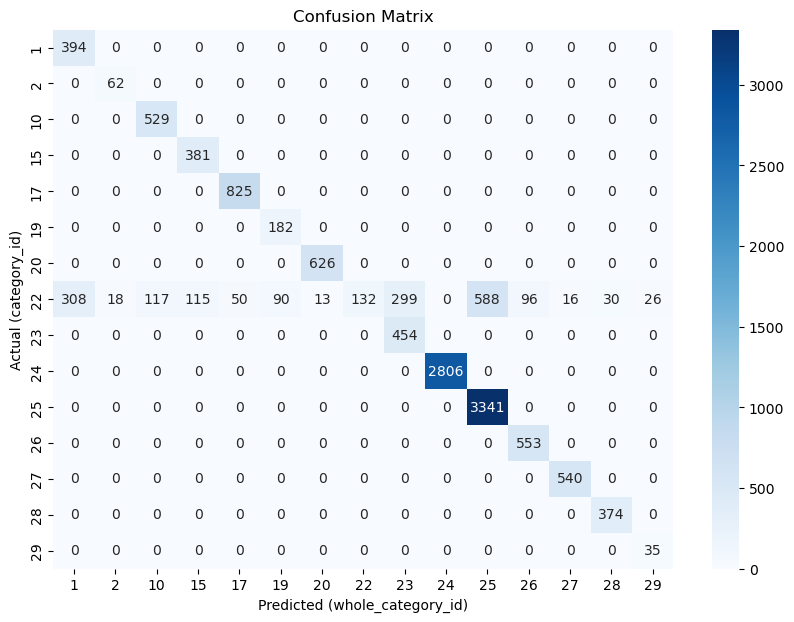

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['category_id'].tolist(), df['whole_category_id'].tolist())

categories = sorted(df['category_id'].unique())

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted (whole_category_id)')
plt.ylabel('Actual (category_id)')
plt.title('Confusion Matrix')
plt.show()


### Training model

In [12]:
df['text'] = df['title'] + ' ' + df['description'] + ' ' + df['captions']

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts = train_df['text'].tolist()
train_labels = train_df['whole_category_id'].tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['whole_category_id'].tolist()

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512) 

In [14]:
class YouTubeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = YouTubeDataset(train_encodings, train_labels)
test_dataset = YouTubeDataset(test_encodings, test_labels)

In [15]:
num_categories = len(df['category_id'].unique())
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_categories)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="steps",     # evaluate during training at each logging step
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()

results = trainer.evaluate()
print(results)

/Users/yejin/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/3900 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 6.49 GB, other allocations: 2.51 GB, max allowed: 9.07 GB). Tried to allocate 96.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).